In [287]:
%matplotlib inline
import math

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import csv
from sklearn import datasets, linear_model, svm, kernel_ridge
from scipy.interpolate import spline


def csv_to_dict(filename):
    """
        dict structure is {
            '11' : { # extent value
                'memory' : [...],
                ...
            },
            ...
        }
    """
    data = defaultdict(lambda : defaultdict(list))
    with open(filename) as f:
        reader = csv.DictReader(f)
        for line in reader:
            line_data = data[int(line['extent'])]
            for k, v in line.iteritems():
                line_data[k].append(float(v))
    return data

def x_vs_y(name, x_key, y_key, extent=None, test_set_size=None, plot_curve=False, skip=1):
    data = csv_to_dict("profile-dump-%s.csv" % name)
   
    fig = plt.figure()
    ax = plt.gca()
    
    x = []
    y = []

    if extent:
        name += " extent: %d" % extent
    extent_range = range(1, 17) if not extent else range(extent, extent + 1)
    extent_range = extent_range[0::skip]
    colors = [ str((0.5 / max(extent_range) * extent)) for extent in extent_range ]
    regrs = {}
    for c, e in zip(colors,extent_range):
        x = data[e][x_key]
        y = data[e][y_key]
        
        x = np.array([[point] for point in x])
        y = np.array(y)
        regrs[e] = fit(x, y, e, c, log_basis=True, test_set_size=test_set_size, plot_curve=plot_curve)
        
    ax.set_title("%s against %s: %s" %(y_key, x_key, name))
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.set_ylim(ymin=0) # must be after plot
    ax.set_ylim(ymax=10000)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=12000)

    plt.legend(loc='best', bbox_to_anchor=(1.4, 1), ncol=2, title='Extent')
    plt.show()
    
    return regrs

log = np.vectorize(lambda x: 1/x)

def fit(x, y, extent, color, log_basis=False, test_set_size=None, plot_curve=False):
    if test_set_size is None:
        x_train, x_test = x, x
        y_train, y_test = y, y
    else:
        x_train, x_test = x[:-test_set_size], x[-test_set_size:]
        y_train, y_test = y[:-test_set_size], y[-test_set_size:]

    if log_basis:
        x_test_transform = log(x_test)
        x_train = log(x_train)

    label = None
    if not plot_curve:
        label = extent
    plt.scatter(x_test, y_test, color=color, label=label)

    if plot_curve:
        regr = linear_model.TheilSenRegressor()
        regr.fit(x_train, y_train)

        x_curve = np.linspace(1, 10000,1000).reshape(1000, 1)
        x_curve_transformed = x_curve
        if log_basis:
            x_curve_transformed = log(x_curve_transformed)
        points = zip(x_curve, regr.predict(x_curve_transformed))
        points.sort(key=lambda point: point[0])
        x_curve, y_curve = zip(*points)
        
        print regr.score(x_test_transform, y_test)
    
        plt.plot(x_curve, y_curve, color=color,
             linewidth=1, label=extent)
    
        return regr


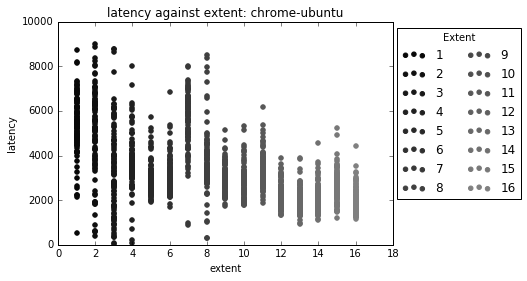

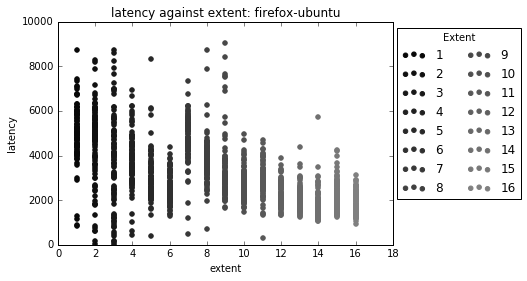

{1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None}

In [275]:
x_vs_y("chrome-ubuntu", "extent", "latency")
x_vs_y("firefox-ubuntu", "extent", "latency")

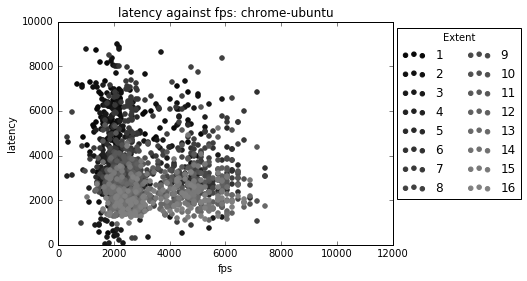

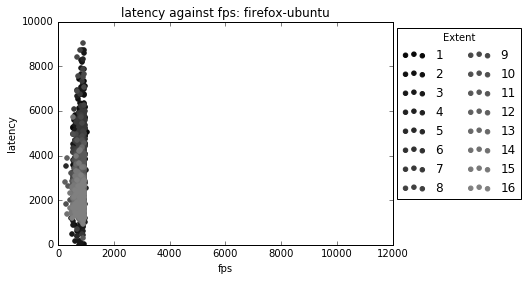

{1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None}

In [278]:
x_vs_y("chrome-ubuntu", "fps", "latency")
x_vs_y("firefox-ubuntu", "fps", "latency")

0.709071327786
0.99773471695
0.998283678659
0.999962429506
0.992041145657
0.997897298864
0.994084462621
0.999811462949
0.999673418022
0.999572660059
0.999046852084
0.999272878969
0.997627832845
0.999578044196
0.997819337987
0.999361934138


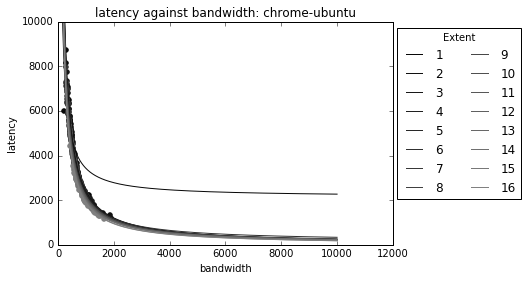

0.750312129821
0.995832611484
0.998985169757
0.999972697526
0.998673280931
0.997614637301
0.998477144741
0.999495858608
0.999749537241
0.999638991944
0.998056736532
0.997797265241
0.998655018363
0.999819217278
0.998339212215
0.998802369574


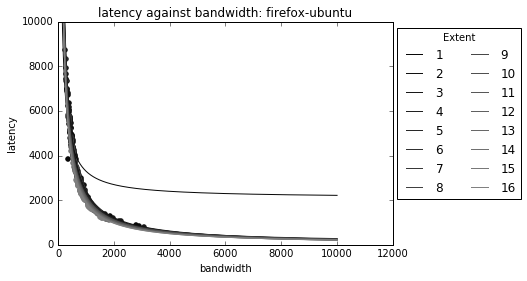

In [290]:
chrome_regrs = x_vs_y("chrome-ubuntu", "bandwidth", "latency", test_set_size=25, plot_curve=True, skip=1)
firefox_regrs = x_vs_y("firefox-ubuntu", "bandwidth", "latency", test_set_size=25, plot_curve=True, skip=1)

In [162]:
def plot_distance(name, data, regrs, target_latency):
    data = csv_to_dict("profile-dump-%s.csv" % name)
    extent_range = range(1, 17)
    latencies = [data[e]['latency'] for e in extent_range]
    latencies = [x for y in latencies for x in y]
    target_latency = sum(latencies) / len(latencies)
    colors = [ str((0.5 / max(extent_range) * extent)) for extent in extent_range ]
    for c, e in zip(colors, extent_range):
        regr = regrs[e]
        
        x_curve = np.linspace(1, 10000,1000).reshape(1000, 1)
        x_curve_transformed = log(x_curve)
        
        target_latencies = np.array([target_latency] * 1000)
        y_curve = regr.predict(x_curve_transformed)
        y_curve = abs(y_curve - target_latencies)

        points = zip(x_curve, y_curve)
        x_curve, y_curve = zip(*points)

        plt.plot(x_curve, y_curve, color=c,
             linewidth=2, label=e)
        
    ax = plt.gca()
    ax.set_title("%s vs %s: %s" %('bandwidth', 'distance to target latency', name))
    ax.set_xlabel('bandwidth')
    ax.set_ylabel('distance to target latency')
    
    ax.set_ylim(ymin=0) # must be after plot
    ax.set_xlim(xmax=12000)
    ax.set_ylim(ymax=6000)
    plt.show()

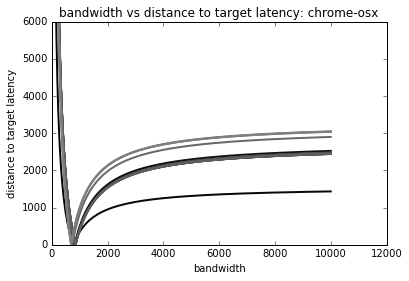

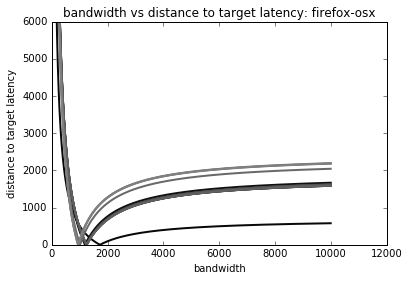

In [165]:
plot_distance('chrome-osx', data, regrs, target_latency)
plot_distance('firefox-osx', data, regrs, target_latency)